# Intro to Poke: Polarization Ray Tracing

_written by Jaren N. Ashcraft_

The first physics submodule of poke is for polarization ray tracing (PRT). All of the physics are done in the `poke.polarization` module, and everything else is just ray data. PRT is an expression of the Fresnel Equations for thin-film polarization in three dimensions. This allows for the propagation of polarization-dependent performance through a ray trace of an optical system

The desireable data product is a Jones Pupil, which is the 3x3 PRT matrix rotated into a local coordinate system. Poke does this using the double pole coordinate system descibed in Chipman, Lam, and Young (2018) Chapter 11.4. This coordinate system is robust to polarization singularities that arise in using the s- and p- basis.

## Initializing a Rayfront as Polarized
So you want a Jones pupil of an optical system, this section will describe how we set up optical system parameters for a `Rayfront` to be built. First, we start with the system properties:
- path to sequential ray trace file
- thin film information

In [2]:
n_film = 1.200 - 1j*7.260  # Al at 600nm from CODE V's cocatings directory
pth_to_lens = '/Users/Work/Desktop/poke/test_files/hubble_test.len'

That wasn't too bad. Note that we only specify a thin film index, which means that the software assumes the substrate is made of entirely silver. Poke also supports thin film stacks, but we will cover that in another tutorial. Now we must specify the surface data. Poke handles surface data with dictionaries as a low-level "user interface", and stores them in a list in the order that they appear in the raytrace.

In [3]:
# The Primary Mirror, 2, 4
s1 = {
    "surf" : 1,         # surface number in zemax
    "coating" : n_film, # refractive index of surface
    "mode" : "reflect"  # compute in reflection ("reflect") or transmission ("transmit")
}

# The Secondary Mirror
s2 = {
    "surf" : 2,
    "coating" : n_film,
    "mode" : "reflect"
}

# The Fold Mirror
s3 = {
    "surf" : 3,
    "coating" : n_film,
    "mode" : "reflect"
}

surflist = [s1,s2,s3]

Now that we have the surface information, we can initialize a `Rayfront` and pass this surface data to it. When ray tracing with CODE V files, it is presently necessary to slightly undersize the normalized pupil radius, so that we don't get vignetting errors.

In [4]:
from poke.poke_core import Rayfront
from poke.poke_math import np

# rayfront parameters
number_of_rays = 20 # across the entrance pupil
wavelength = 0.6e-6
pupil_radius = 1.2 # semi-aperture of Hubble
max_field_of_view = 0.08 # degrees

rays = Rayfront(number_of_rays,wavelength,pupil_radius,max_field_of_view,circle=False)

norm fov =  [0. 0.]
base ray shape  (4, 400)


Now we have a standard Rayfront, which is just a bundle of un-traced rays now. To enable the physical optics capabilities, we need to call the `Rayfront.as_polarized()` method and pass it the surface list.

In [5]:
rays.as_polarized(surflist)

Then we can propagate it through the optical system with the `rays.trace_rayset()` method by supplying the path specified earlier

In [6]:
import zosapi
rays.trace_rayset(pth_to_lens)

res /Users/Work/Desktop/poke/test_files/hubble_test.len
CODE V warning: Warning: Buffer number 0 does not exist.  Nothing deleted. 
CODE V warning: Warning: Solves may be affected by a change in the reference wavelength 
global coordinate reference set to surface 1
maxrays =  400
CODE V warning: Warning: Buffer number 1 does not exist.  Nothing deleted. 
1 Raysets traced through 3 surfaces


Now the rays have position and angle. This tells us a little bit about how `Rayfronts` are constructed. They have some attribute `Rayfront._Data` that holds on to the coordinate `_`. The following are accessible:
- xData: position in x axis
- yData: position in y axis
- zData: position in z axis
- lData: direction cosine in x axis
- mData: direction cosine in y axis
- nData: direction cosine in z axis
- l2Data: surface normal direction cosine in x axis
- m2Data: surface normal direction cosine in x axis
- n2Data: surface normal direction cosine in x axis

Each of these are numpy arrays which have shape [raybundle,surface,coordinate]. We can plot the position and direction cosines on the primary mirror:

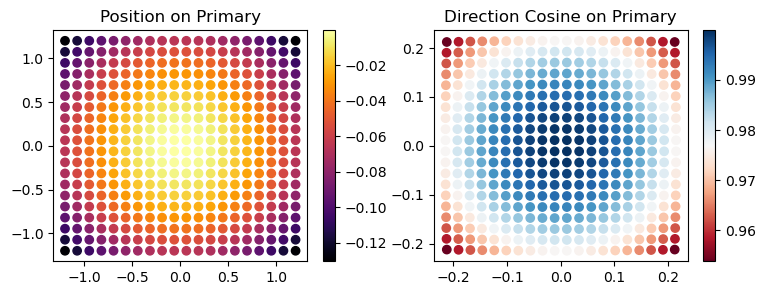

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=[9,3])
plt.subplot(121)
plt.title('Position on Primary')
plt.scatter(rays.xData[0,0],rays.yData[0,0],c=rays.zData[0,0], cmap='inferno')
plt.colorbar()
plt.subplot(122)
plt.title('Direction Cosine on Primary')
plt.scatter(rays.lData[0,0],rays.mData[0,0],c=rays.nData[0,0],cmap='RdBu')
plt.colorbar()
plt.show()

Turns out all we need is angle of incidence, direction cosines, and refractive index data to compute the polarized exit pupil. If your final axis isn't aligned with the z-axis this is slightly more involved but for now let's keep it simple:

In [8]:
rays.compute_jones_pupil(aloc=np.array([0., -1., 0.]))

And we can use poke's built-in plotting routine to display it. Turns out Silver is pretty good in the infrared!

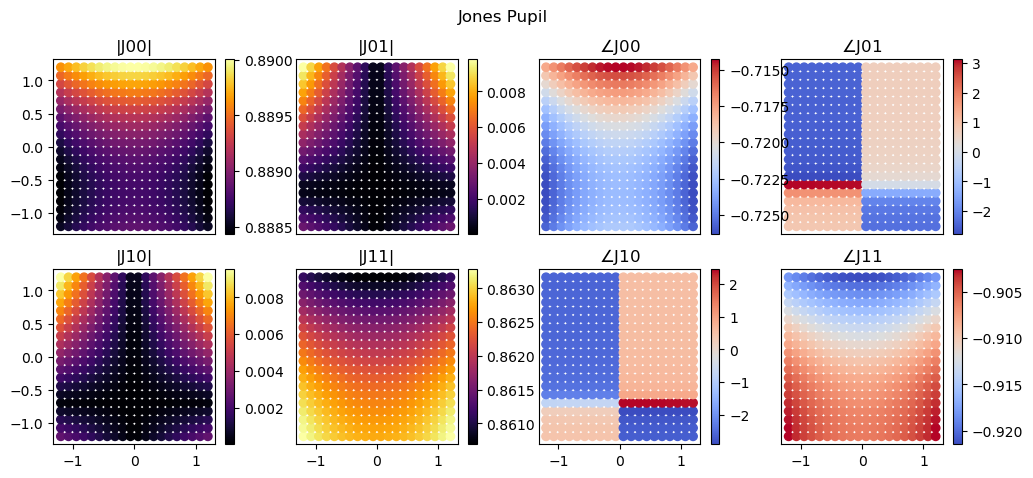

In [9]:
import poke.plotting as plot
plot.jones_pupil(rays, coordinates='polar')

## Verifying the Physics
Now we have illustrated that we can return a Jones pupil, but is it accurate? To check this, we can compare the results to the ouput of `POLGRID.seq`. This is a CODE V macro that does the exact same polarization ray tracing the Poke does. It has a macro-only interface (as far as I know), so we will use the following CODE V seqence to run POLGRID.

```C
! Define input variables
num ^input_array(2,400) ^output_array(43,401) ^input_ray(4)
num ^success 
^nrays == 400 
^nrays_across == sqrt(^nrays) 
^x_start == -1
^x_end == 1
^y_start == -1
^y_end == 1
! compute step size and construct input array
^step_size == absf(^y_start-^y_end)/(^nrays_across-1)
^x_cord == ^x_start
^y_cord == ^y_start
^next_row == 0
FOR ^iter 1 ^nrays
    ^input_array(1,^iter) == ^x_cord
    ^input_array(2,^iter) == ^y_cord
    ! update the x_cord
    ^x_cord == ^x_cord + ^step_size
    IF modf(^iter,^nrays_across) = 0
        ^next_row == 1
    END IF
    IF ^next_row = 1
        ! update y_cord
        ^y_cord == ^y_cord + ^step_size
        ! reset x_cord
        ^x_cord == ^x_start
        ! reset next_row
        ^next_row == 0
    END IF
END FOR
! Run POLGRID 
^success == POLGRID(1, 1, 1, 0, ^nrays, ^input_array, ^output_array) 
wri ^success
! Write output_array to text file
BUF DEL B1
^result == ARRAY_TO_BUFFER(^output_array,1,0)
BUF EXP B1 SEP "polgrid_output.txt"
```

Before executing this, we will need to set up our coated HST for comparison. We will use the REFL_AL_450nm_700nm.mul coating for comparison, which comes installed with CODE V in the "coating" directory. We then save the macro above as `run_polgrid.seq` to perform the polarization ray trace. You can find both the coated HST model and the polgrid macro in the `experiments/physics_validation/` directory of `poke`.

In [10]:
# Compare to the polgrid output
from poke.poke_math import np
pth = '../../experiments/physics_validation/polgrid_output.txt'
polgrid_data = np.genfromtxt(pth, delimiter=' ')

# jones matrix indices, see CODE V docs for the remaining rows
jxx_r = polgrid_data[20,1:]
jxx_i = polgrid_data[21,1:]
jxy_r = polgrid_data[22,1:]
jxy_i = polgrid_data[23,1:]
jyx_r = polgrid_data[24,1:]
jyx_i = polgrid_data[25,1:]
jyy_r = polgrid_data[26,1:]
jyy_i = polgrid_data[27,1:]

Jmat = np.zeros([jxx_r.shape[0], 2, 2], dtype=np.complex128)
Jmat[..., 0, 0] = jxx_r + 1j*jxx_i
Jmat[..., 0, 1] = jxy_r + 1j*jxy_i
Jmat[..., 1, 0] = jyx_r + 1j*jyx_i
Jmat[..., 1, 1] = jyy_r + 1j*jyy_i

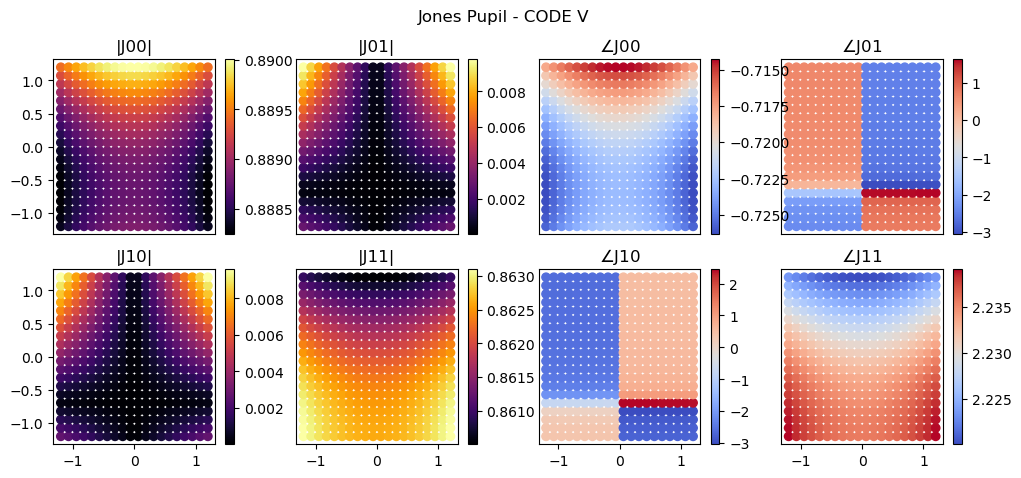

In [11]:
x, y = rays.xData[0, 0], rays.yData[0, 0]

fig, axs = plt.subplots(figsize=[12, 5], nrows=2, ncols=4)
plt.suptitle("Jones Pupil - CODE V")
for j in range(2):
    for k in range(2):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(x, y, c=np.abs(Jmat[..., j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(2):
    for k in range(2):

        if j == 1:
            if k == 1:
                offset = 0
        ax = axs[j, k + 2]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        sca = ax.scatter(x, y, c=np.angle(Jmat[..., j, k]) + offset, cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

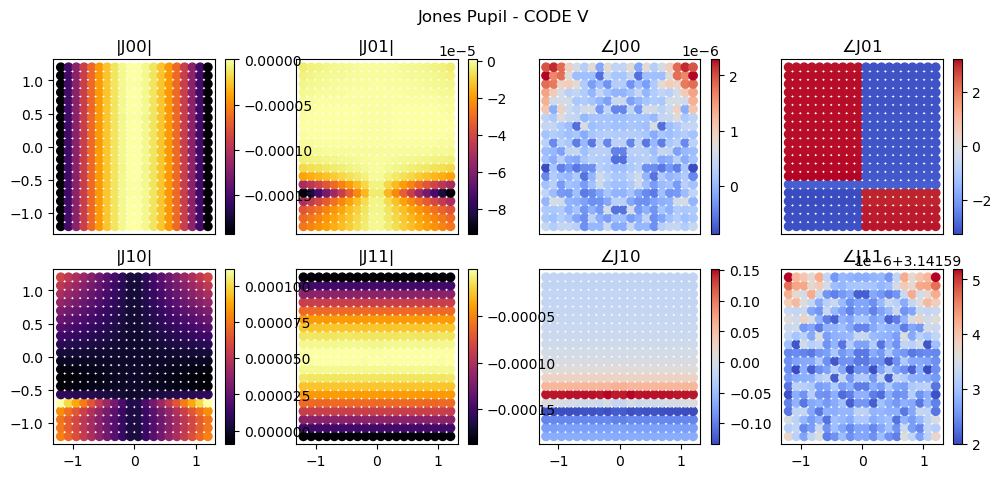

In [12]:
poke_jones = rays.jones_pupil[-1]
fig, axs = plt.subplots(figsize=[12, 5], nrows=2, ncols=4)
plt.suptitle("Jones Pupil - CODE V")
for j in range(2):
    for k in range(2):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(x, y, c=np.abs(Jmat[..., j, k]) - np.abs(poke_jones[..., j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(2):
    for k in range(2):

        if k == 1:
            offset = 0
        else:
            offset = 0
        ax = axs[j, k + 2]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        sca = ax.scatter(x, y, c=np.angle(Jmat[..., j, k]) + offset - np.angle(poke_jones[..., j, k]), cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

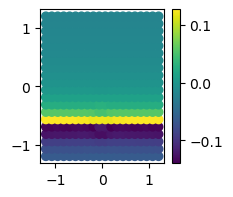

In [13]:
from skimage.restoration import unwrap_phase
j01angle = np.angle(Jmat[..., 0, 1]) - np.angle(poke_jones[..., 0, 1])
plt.figure(figsize=[2,2])
plt.scatter(x, y, c=unwrap_phase(j01angle) + np.pi)
plt.colorbar()
plt.show()

## Debugging the discrepancy

In [14]:
import zosapi
zosapi.App()

# create Zemax equivalent rayfront
pth_to_lens_zmx = '/Users/Work/Desktop/poke/test_files/Hubble_Test.zmx'

s1 = {
    "surf" : 2,         # surface number in zemax
    "coating" : n_film, # refractive index of surface
    "mode" : "reflect"  # compute in reflection ("reflect") or transmission ("transmit")
}

# The Secondary Mirror
s2 = {
    "surf" : 4,
    "coating" : n_film,
    "mode" : "reflect"
}

# The Fold Mirror
s3 = {
    "surf" : 8,
    "coating" : n_film,
    "mode" : "reflect"
}



rays_zmx = Rayfront(number_of_rays,wavelength,pupil_radius,max_field_of_view,circle=False)
rays_zmx.as_polarized([s1, s2, s3])
rays_zmx.trace_rayset(pth_to_lens_zmx)

norm fov =  [0. 0.]
base ray shape  (4, 400)
tracing with global coordinates
tracing with global coordinates
tracing with global coordinates
1 Raysets traced through 3 surfaces


In [15]:
rays_zmx.lData.shape

(1, 3, 400)

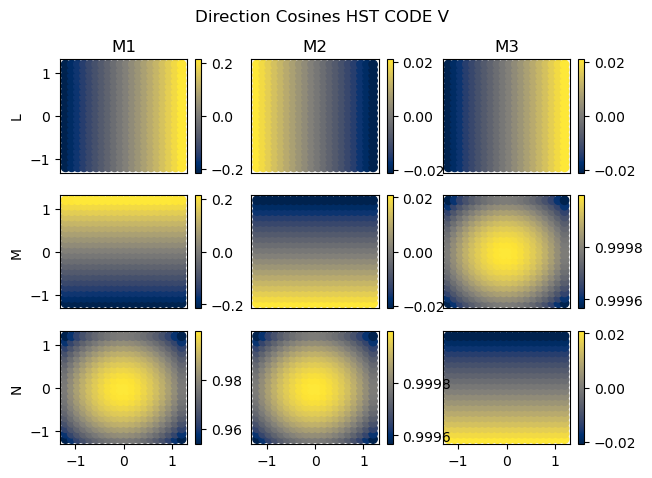

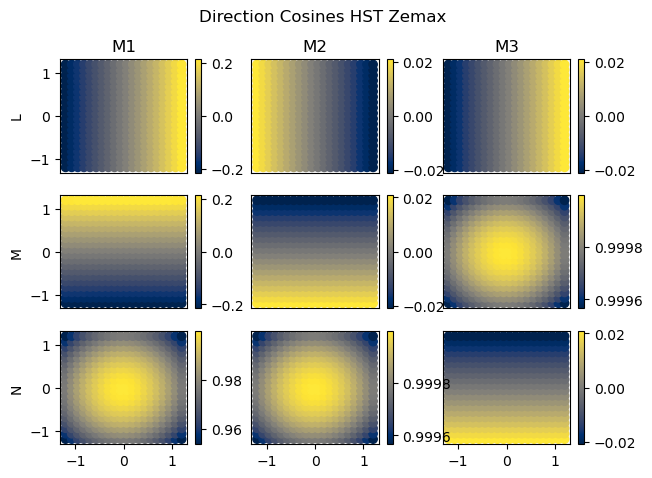

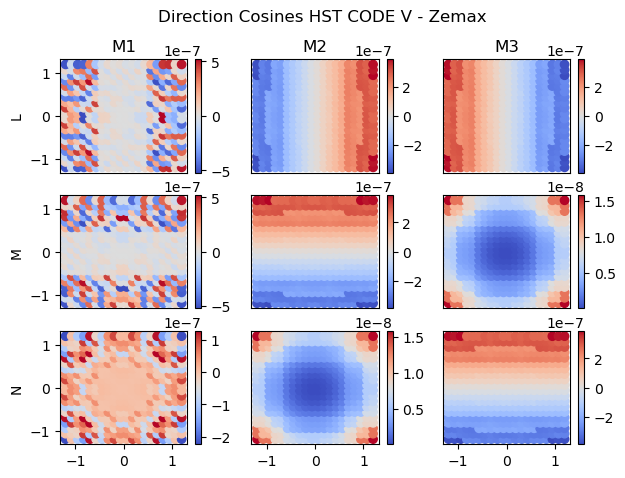

In [16]:
def plot_raydir(rf, rf2=None, code='Zemax', cmap='cividis'):
    fig, axs = plt.subplots(figsize=[7, 5], nrows=3, ncols=3)
    plt.suptitle(f"Direction Cosines HST {code}")
    for j in range(3):
        for k in range(3):
            
            ax = axs[j, k]

            if j == 0:
                if rf2 is None:
                    data = rf.lData[0, k]
                else:
                    data = rf.lData[0, k] - rf2.lData[0, k]
                ax.set_ylabel('L')
                ax.set_title(f'M{k+1}')

            elif j == 1:
                if rf2 is None:
                    data = rf.mData[0, k]
                else:
                    data = rf.mData[0, k] - rf2.mData[0, k]
                ax.set_ylabel('M')

            elif j == 2:
                if rf2 is None:
                    data = rf.nData[0, k]
                else:
                    data = rf.nData[0, k] - rf2.nData[0, k]
                ax.set_ylabel('N')

            sca = ax.scatter(x, y, c=data, cmap=cmap)
            fig.colorbar(sca, ax=ax)

            # clear interior axes
            if j < 2:
                ax.xaxis.set_visible(False)

            if k > 0:
                ax.yaxis.set_visible(False)

plot_raydir(rays, code='CODE V')
plot_raydir(rays_zmx, code='Zemax')
plot_raydir(rays, rf2=rays_zmx, code='CODE V - Zemax', cmap='coolwarm')

In [17]:
"""  
from RSI 1 0 0 0, wavelenth = 600nm         
P11R        P11I        P12R        P12I        P13R        P13I
P21R        P21I        P22R        P22I        P23R        P23I
P31R        P31I        P32R        P32I        P33R        P33I

"""

P11, P12, P13 = -0.66469 + 1j*0.58915, 0.00287 + 1j*0.00196, 0.
P21, P22, P23 = 0.01385 - 1j*0.01228, -0.00006 - 1j*0.00004, 0.
P31, P32, P33 =  -0.00289 - 1j*0.00193, 0.53173-1j*0.67918, 0.

In [18]:
rays_zmx.compute_jones_pupil(aloc=np.array([0., -1., 0.]))

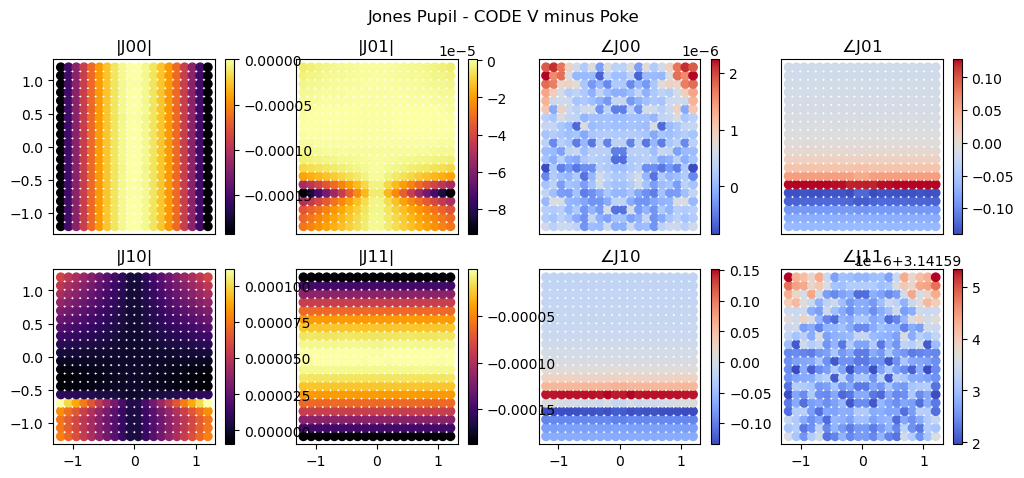

In [93]:
from skimage.restoration import unwrap_phase

poke_jones = rays_zmx.jones_pupil[-1]
fig, axs = plt.subplots(figsize=[12, 5], nrows=2, ncols=4)
plt.suptitle("Jones Pupil - CODE V minus Poke")
for j in range(2):
    for k in range(2):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(x, y, c=np.abs(Jmat[..., j, k]) - np.abs(poke_jones[..., j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(2):
    for k in range(2):

        if k == 1:
            if j == 0:
                offset = np.pi
        else:
            offset = 0
        ax = axs[j, k + 2]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        sca = ax.scatter(x, y, c=unwrap_phase(np.angle(Jmat[..., j, k]) + offset - np.angle(poke_jones[..., j, k])), cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

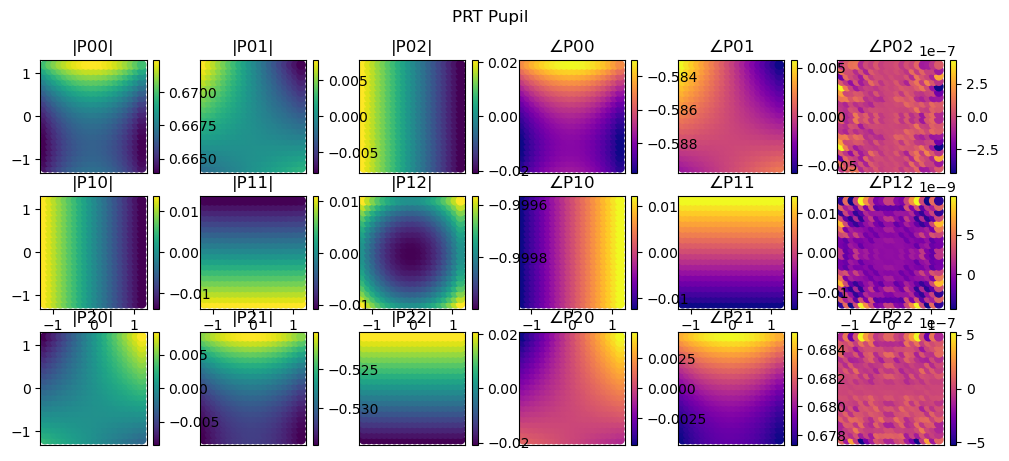

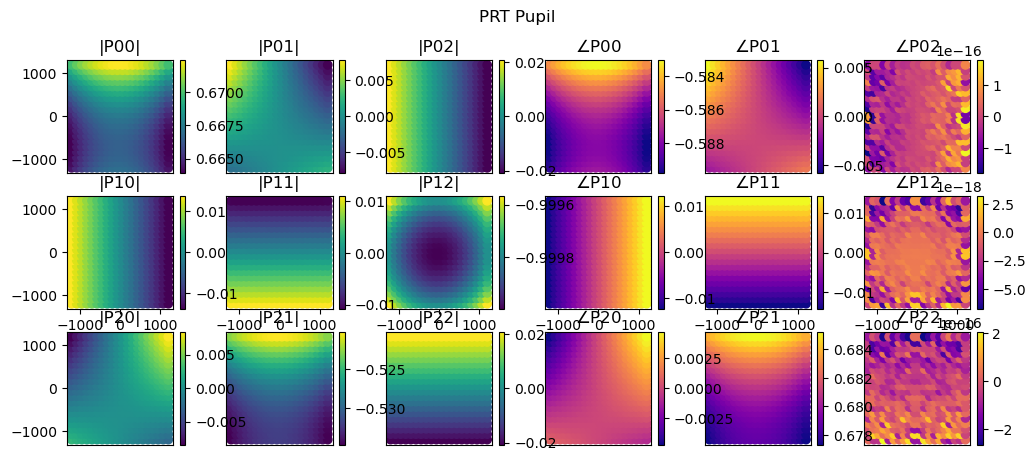

In [20]:
import poke.plotting as plot
plot.prt_pupil(rays, coordinates='cartesian')
plot.prt_pupil(rays_zmx, coordinates='cartesian')

In [21]:
rays.P_total[0].shape

(400, 3, 3)

In [22]:
pth = 'C:/Users/work/Desktop/poke/test_files/prt_output.txt'
data = np.genfromtxt(pth).T

P11 = data[0] + 1j*data[1]
P12 = data[2] + 1j*data[3]
P13 = data[4] + 1j*data[5]

P21 = data[5] + 1j*data[6]
P22 = data[7] + 1j*data[8]
P23 = data[9] + 1j*data[10]

P31 = data[11] + 1j*data[12]
P32 = data[13] + 1j*data[14]
P33 = data[15] + 1j*data[16]

prt_cv = np.array([[P11, P12, P13],
                   [P21, P22, P23],
                   [P31, P32, P33]])
prt_cv = prt_cv.reshape([3,3,32,32])

def prt_imshow(Pmat, coordinates='cartesian'):

    if coordinates == 'polar':
        op1 = np.abs
        cm1 = 'inferno'
        op2 = np.angle
        cm2 = 'coolwarm'

    elif coordinates == 'cartesian':
        op1 = np.real
        cm1 = 'viridis'
        op2 = np.imag
        cm2 = 'plasma'

    fig, axs = plt.subplots(figsize=[12, 5], nrows=3, ncols=6)
    plt.suptitle("PRT Pupil")
    for j in range(3):
        for k in range(3):
            ax = axs[j, k]
            ax.set_title("|P{j}{k}|".format(j=j, k=k))
            sca = ax.imshow(op1(Pmat[j, k]), cmap=cm1, origin='lower')
            fig.colorbar(sca, ax=ax)

            # turn off the ticks
            if j != 1:
                ax.xaxis.set_visible(False)
            if k != 0:
                ax.yaxis.set_visible(False)

    for j in range(3):
        for k in range(3):

            ax = axs[j, k + 3]
            ax.set_title(r"$\angle$" + "P{j}{k}".format(j=j, k=k))
            sca = ax.imshow(op2(Pmat[j, k]), cmap=cm2, origin='lower')
            fig.colorbar(sca, ax=ax)

            # turn off the ticks
            if j != 1:
                ax.xaxis.set_visible(False)

            ax.yaxis.set_visible(False)
    plt.show()

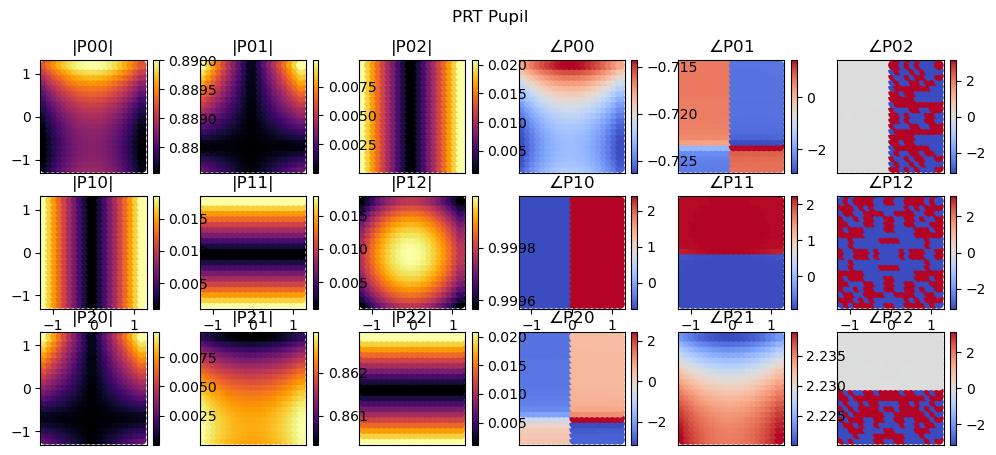

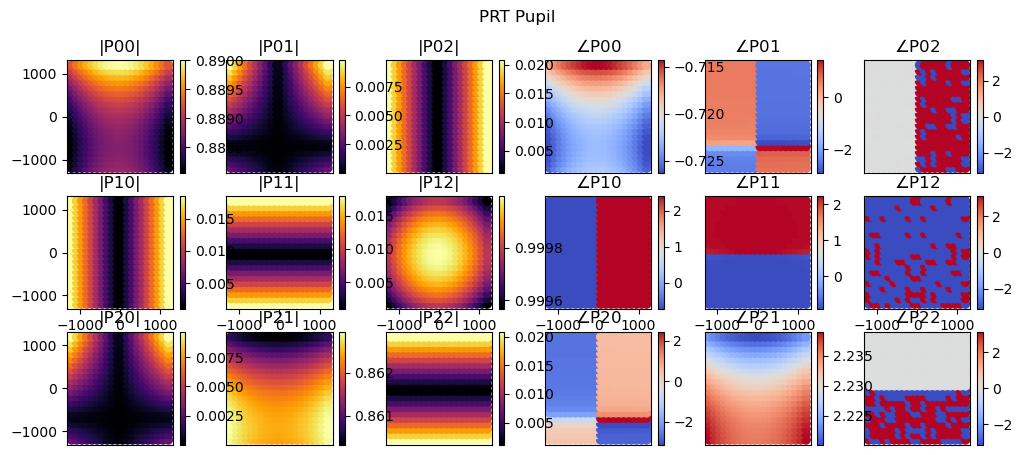

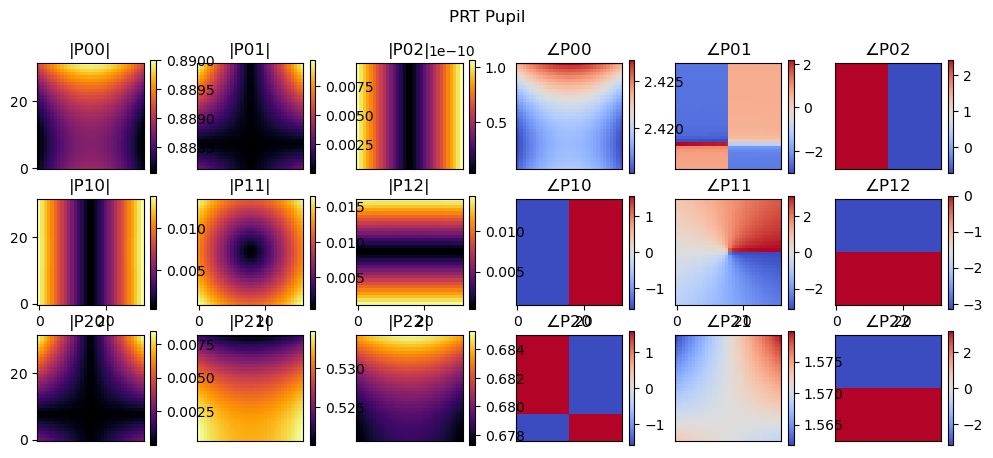

In [23]:
plot.prt_pupil(rays, coordinates='polar')
plot.prt_pupil(rays_zmx, coordinates='polar')
prt_imshow(prt_cv, coordinates='polar')

# Try out John Krist's macro

The operating principle behind John Krist's polarization ray tracing macro is that we assume that Zemax can correctly perform PRT. With perfect knowledge of electric field, it then follows that we can send in X- and Y-polarized light to sense the full Jones pupil, i.e.

$$
\begin{pmatrix}
E_{xx} \\
E_{yx} \\
\end{pmatrix}
=
\begin{pmatrix}
E_{xx} & E_{xy} \\
E_{yx} & E_{yy} \\
\end{pmatrix}
\begin{pmatrix}
1 \\
0 \\
\end{pmatrix}
$$

$$
\begin{pmatrix}
E_{xy} \\
E_{yy} \\
\end{pmatrix}
=
\begin{pmatrix}
E_{xx} & E_{xy} \\
E_{yx} & E_{yy} \\
\end{pmatrix}
\begin{pmatrix}
0 \\
1 \\
\end{pmatrix}
$$

Thankfully John has provided us with this macro. So we set up a poltrace and just load up the data to see if the Jones pupil is the same.

In [82]:
pol = ['x', 'y']
data = []
for p in pol:
    pth = f'C:/Users/Work/Desktop/poke/experiments/physics_validation/hst_m1m2m3_test__{p}in_600nm.txt'
    loaded = np.genfromtxt(pth, skip_header=1, encoding='UTF-16')
    _xpup = loaded[..., 0]
    _ypup = loaded[..., 1]
    _Ex = loaded[..., 3] + 1j * loaded[..., 4]
    _Ey = loaded[..., 5] + 1j * loaded[..., 6]
    _Ez = loaded[..., 7] + 1j * loaded[..., 8]

    if (p == 'x') or (p=='m45'):
        Exx = _Ex
        Eyx = _Ey

    else:
        Exy = _Ex
        Eyy = _Ey

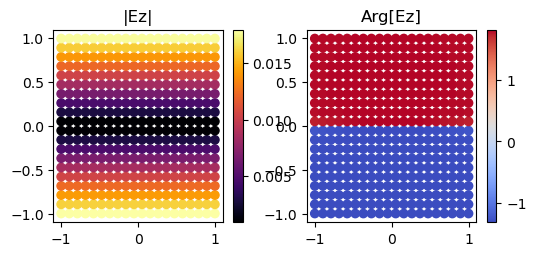

In [92]:
plt.figure(figsize=[6,2.5])
plt.subplot(121)
plt.title('|Ez|')
plt.scatter(_xpup, _ypup, c=np.abs(_Ez), cmap='inferno')
plt.colorbar()
plt.subplot(122)
plt.title('Arg[Ez]')
plt.scatter(_xpup, _ypup, c=np.angle(_Ez), cmap='coolwarm')
plt.colorbar()
plt.show()


In [84]:
Jmat_zmx = np.array([[Exx, Exy],[Eyx, Eyy]])
Jmat_zmx.shape

(2, 2, 400)

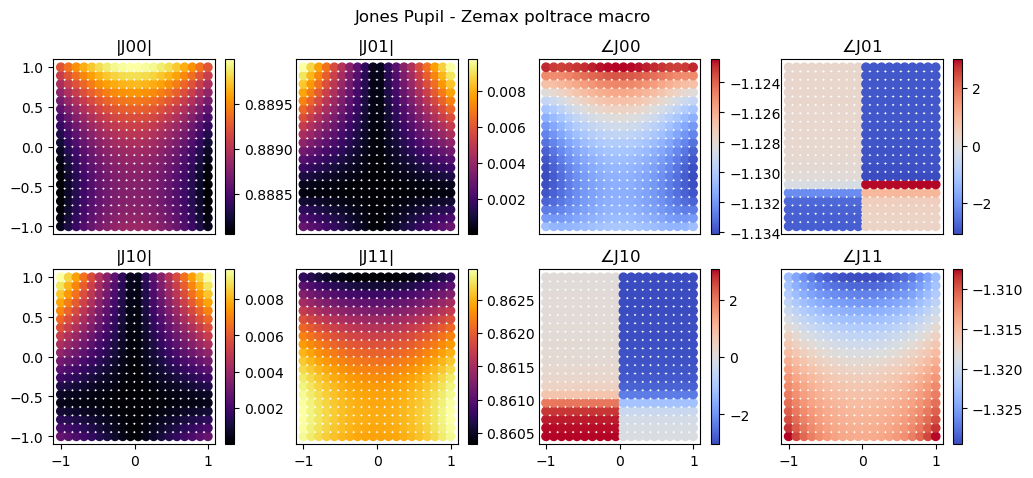

In [85]:
poke_jones = rays.jones_pupil[-1]
fig, axs = plt.subplots(figsize=[12, 5], nrows=2, ncols=4)
plt.suptitle("Jones Pupil - Zemax poltrace macro")
for j in range(2):
    for k in range(2):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(_xpup, _ypup, c=np.abs(Jmat_zmx[j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(2):
    for k in range(2):

        if k == 1:
            offset = 0
        else:
            offset = 0
        ax = axs[j, k + 2]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        sca = ax.scatter(_xpup, _ypup, c=(np.angle(Jmat_zmx[j, k])), cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

In [86]:
len(_xpup)

400

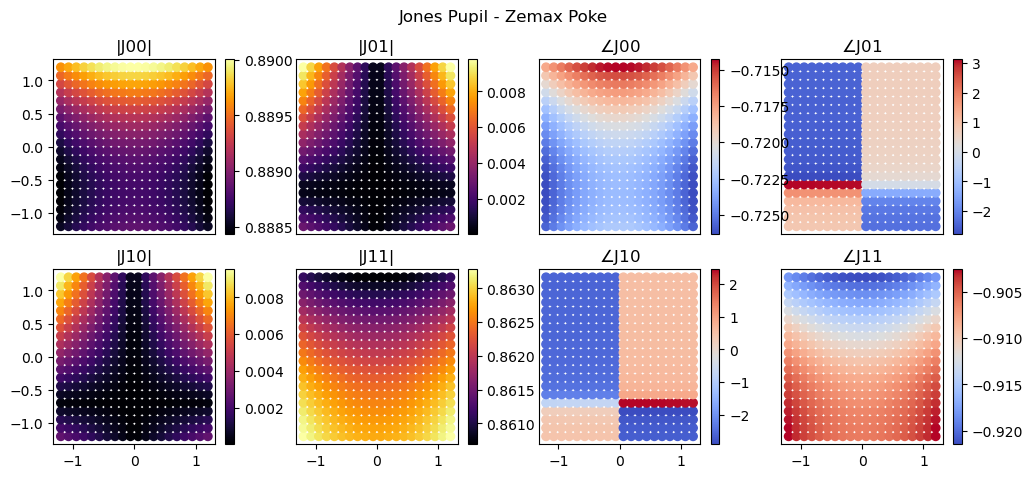

In [87]:
fig, axs = plt.subplots(figsize=[12, 5], nrows=2, ncols=4)
plt.suptitle("Jones Pupil - Zemax Poke")
for j in range(2):
    for k in range(2):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(x, y, c=np.abs(poke_jones[..., j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(2):
    for k in range(2):

        if k == 1:
            offset = 0
        else:
            offset = 0
        ax = axs[j, k + 2]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        sca = ax.scatter(x, y, c=(np.angle(poke_jones[..., j, k])), cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

0 1


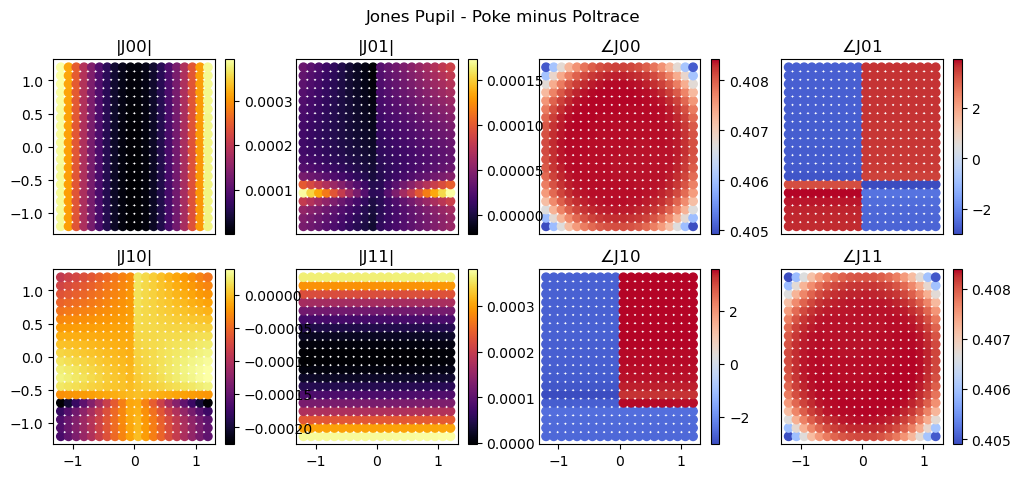

In [107]:
from skimage.restoration import unwrap_phase

fig, axs = plt.subplots(figsize=[12, 5], nrows=2, ncols=4)
plt.suptitle("Jones Pupil - Poke minus Poltrace")
for j in range(2):
    for k in range(2):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(x, y, c=np.abs(poke_jones[..., j, k]) - np.abs(Jmat_zmx[j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(2):
    for k in range(2):

        ax = axs[j, k + 2]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        if (j == 0) and (k == 1):
            print(j,k)
            sca = ax.scatter(x, y, c=(np.angle(poke_jones[..., j, k]) - (np.angle(Jmat_zmx[j, k]))), cmap="coolwarm")
        else:
            sca = ax.scatter(x, y, c=(np.angle(poke_jones[..., j, k]) - np.angle(Jmat_zmx[j, k])), cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

In [63]:
len(poke_jones[...,0,0])

400

In [48]:
(x[...,0]-x[...,1])/pupil_radius

-0.10526666666666648